# Rotating Star Modeling

### Caltech Summer 2019

Modeling to show that a rotating **disk** is needed to explain the features in FU Ori objects. Started 19 July 2019.

### Imports 

In [61]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_new import *

### Constants (astronomy is in cgs, right?)

In [62]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

## Star class

In [63]:
class Star:
    
    # Initializer / Instance Attributes
    def __init__(self, temp, grav, m_star, r_star, directory, inc):
        self.temp = temp
        self.grav = grav
        self.m_star = m_star
        self.r_star = r_star
        self.directory = directory
        self.inc = inc
        
        self.area = 4*np.pi*r_star**2
        
        # Non-interpolated quantities
        self.lums = 0
        self.wavelengths = 0
        
        # Interpolated quantities
        self.lums_interp = 0
        self.wavelengths_interp = 0
        self.lums_broad = 0


    # instance methods
    
    # Setting the luminosity
    def setSpectrumBlackbody(self, waves):
        self.wavelengths, self.lums = getBlackbody(waves, self.temp)
        self.wavelengths = self.wavelengths*1e8

    def setSpectrumFromDirec(self, spec_model, template_temp, template_grav):
        if spec_model == 'stellar atmospheres':
            try:
                self.wavelengths, self.lums = getLumFromDirec(self.temp, self.grav, self.directory, spec_model)
                print('Used stellar atmosphere at T = ' + str(int(self.temp)) + '.')
            except:
                print('No stellar atmosphere for annulus of T = ' + str(int(self.temp)) + '. Used blackbody.')
                direc_waves = getLumFromDirec(template_temp, template_grav, self.directory, spec_model)[0]
                self.wavelengths = getBlackbody(direc_waves*1e-8, self.temp)[0]/1e-8
                self.lums = getBlackbody(direc_waves*1e-8, self.temp)[1]
        else:
            print('Model not available. Choose another or use blackbody setting.')
            
    def prepareSpectrum(self, wave_lower, wave_upper, binning, interp_type):
        self.wavelengths_interp, self.lums_interp=\
            prepareAnnulus(self.wavelengths, self.lums, wave_lower, wave_upper, binning, interp_type)
    
    # Just plotting luminosity (**not multiplied by area**)
    def getLuminosity(self, wave_lower, wave_upper, data_type):
        if data_type == 'non-interpolated':
            waves, lums = self.wavelengths, self.lums
        elif data_type == 'interpolated':
            waves, lums = self.wavelengths_interp, self.lums_interp
        elif data_type == 'broadened':       
            waves, lums = self.wavelengths_interp, self.lums_broad
        else:
            print('Data type does not exist.')
            
        ind_lower = np.searchsorted(waves, wave_lower)
        ind_upper = np.searchsorted(waves, wave_upper)
        return (waves[ind_lower:ind_upper], lums[ind_lower:ind_upper])

    # Broadening
    def broadenStellarSpectrum(self):
        waves = self.wavelengths_interp
        lums = self.lums_interp

        rot_profile = stellarRotationProfileNorm(self.m_star, waves, np.mean(waves), self.r_star, self.inc)
        lums_broad = convolve(lums, rot_profile)
        self.lums_broad = lums_broad

In [69]:
TEMP = 4400
GRAV = 4.0
M_STAR = M_SUN
R_STAR = R_SUN
ROT_INC = 60.
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'
test_star = Star(TEMP, GRAV, M_STAR, R_STAR, DIREC, np.radians(ROT_INC)) 

In [70]:
test_star.setSpectrumFromDirec('stellar atmospheres', TEMP, GRAV)

Used stellar atmosphere at T = 4400.


In [72]:
START = 22500
END = 24000

 

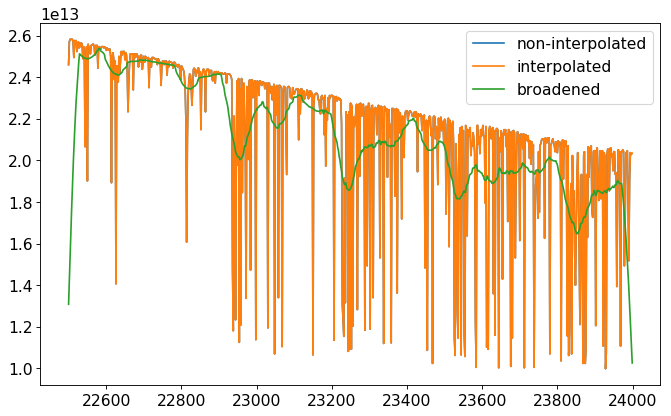

In [73]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
wav, lum = test_star.getLuminosity(START, END, 'non-interpolated')
wav2, lum2 = test_star.getLuminosity(START, END, 'interpolated')
wav3, lum3 = test_star.getLuminosity(START, END, 'broadened')


plt.plot(wav, lum, label = 'non-interpolated')
plt.plot(wav2, lum2, label = 'interpolated')
plt.plot(wav3, lum3, label = 'broadened')

plt.legend()
plt.show()

### Reading in infrared SED from Hillenbrand et al. 2018

In [74]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Papers/Gaia 17bpi/'

DIST = 1.27e3*3.08567758128e18

In [75]:
def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [76]:
newtxt = getDataArray(PATH + 'Gaia17bpi.merged.txt')

wavesDATA_INF = newtxt[:,0] 
fluxesDATA_INF = newtxt[:,1]

In [77]:
wavesDATA_INF

array([ 7138.6898,  7140.0517,  7141.4137, ..., 25663.331 , 25666.907 ,
       25670.485 ])

In [78]:
REGIONS = np.array([(1e3, 8.5e3), (13e3, 15e3), (17.5e3, 19.8e3), (24.2e3, 26.5e3)])

In [79]:
def cleanPoints(waves, lums, regions):
    waves_final, lums_final = [], []
    exclude = []
    for i in range(len(regions)):
        start, end = regions[i]
        ind_lower = np.searchsorted(waves, int(start))
        ind_upper = np.searchsorted(waves, end)
        bad_points = np.arange(ind_lower, ind_upper+1, 1)
        for i in range(len(bad_points)):
            exclude.append(bad_points[i])

    waves_final = np.delete(waves, exclude)
    lums_final = np.delete(lums, exclude)
    return waves_final, lums_final

waves_DAT, fluxes_DAT = cleanPoints(wavesDATA_INF, fluxesDATA_INF, REGIONS)

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if sys.path[0] == '':
C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


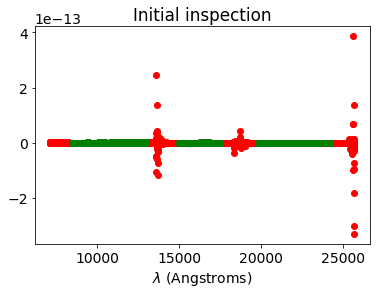

In [80]:
plt.title('Initial inspection')
plt.xlabel(r'$\lambda$ (Angstroms)')
plt.plot(wavesDATA_INF, fluxesDATA_INF, 'ro')
plt.plot(waves_DAT, fluxes_DAT, 'go')
plt.show()

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


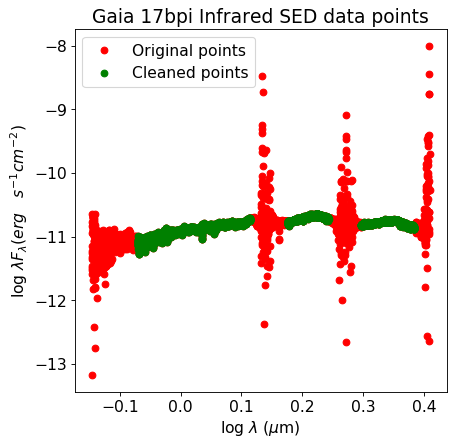

In [81]:
fig=plt.figure(figsize=(6, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')

plt.title('Gaia 17bpi Infrared SED data points')

plt.plot(np.log10(wavesDATA_INF*1e-4), np.log10(fluxesDATA_INF * wavesDATA_INF), 'ro', label='Original points')
plt.plot(np.log10(waves_DAT*1e-4), np.log10(fluxes_DAT * waves_DAT), 'go', label='Cleaned points')
plt.legend()
plt.show()

## Plotting Rotating Star Model with Data

Recall:
$$F = \dfrac{L^\text{TOT (star)}}{4\pi d^2}$$

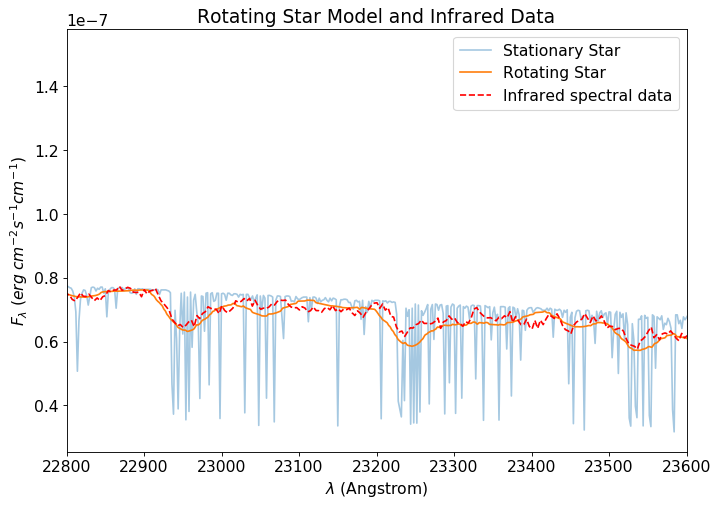

In [85]:
fig=plt.figure(figsize=(10, 7), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.title('Rotating Star Model and Infrared Data')
plt.plot(wav2, 1e1*lum2*R_STAR**2/(DIST**2), '-', alpha=0.4,label='Stationary Star')
plt.plot(wav3, 1e1*lum3*R_STAR**2/(DIST**2), '-',label='Rotating Star')
plt.plot(waves_DAT, fluxes_DAT*1e8, 'r--', label='Infrared spectral data')

plt.xlabel(r'$\lambda$ (Angstrom)')
plt.ylabel(r'$F_\lambda\; (erg \;cm^{-2} s^{-1} cm^{-1})$')
plt.xlim(22800, 23600)
plt.legend()
# plt.ylim(0.3e-7,1.1e-7)
# plt.savefig('test.png')
plt.show()